# Stereoisomer testing on ChiENN - axiale chiralit√§t

## Importing section

In [1]:
import sys

import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import AllChem

from ptgnn.model.modules.custom_wrapper import CustomWrapper

sys.path.append("../../../../")

from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer
from ptgnn.transform import edge_graph_transform
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.loading.chienn_collate import collate_with_circle_index

## Define SMILES strings

In [2]:
smiles_list = [
    "C(C(=O)O)1C=CC=C(N(O)O)C=1\C2/C(N(O)O)=CC=CC(C(=O)O)=2",
    "C(C(=O)O)1C=CC=C(N(O)O)C=1\C2/C(C(=O)O)=CC=CC(N(O)O)=2",
    "C(N(O)O)1C=CC=C(C(=O)O)C=1\C2/C(N(O)O)=CC=CC(C(=O)O)=2",
    "C(N(O)O)1C=CC=C(C(=O)O)C=1\C2/C(C(=O)O)=CC=CC(N(O)O)=2",

    'N1(C2=C(I)C=CC=C2C)C(Br)=CC=C1C |wU:1.7,0.9,(15.40,-10.23,;15.40,-9.23,;14.54,-8.73,;13.67,-9.23,;14.54,-7.73,;15.40,-7.23,;16.26,-7.73,;16.27,-8.73,;17.13,-9.22,;14.60,-10.82,;13.64,-10.52,;14.90,-11.77,;15.90,-11.77,;16.20,-10.82,;17.16,-10.52,)|',
    'N1(C(C)=CC=C1Br)C1C(C)=CC=CC=1I |wU:0.5,wD:0.0,(16.58,-10.58,;17.38,-11.17,;18.34,-10.87,;17.08,-12.12,;16.07,-12.12,;15.77,-11.17,;14.81,-10.87,;16.58,-9.58,;17.45,-9.08,;18.31,-9.57,;17.44,-8.08,;16.58,-7.58,;15.71,-8.08,;15.71,-9.08,;14.84,-9.58,)|'
]

rdkit does not currently support axial chirality:
https://github.com/rdkit/rdkit/discussions/5584

thus add manually

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

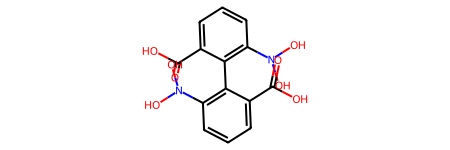

[]
Bond 1 stereo: STEREONONE
Bond 21 stereo: STEREONONE


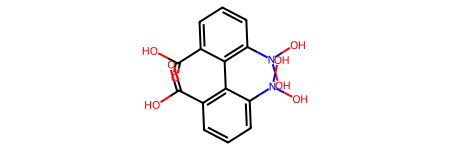

[]
Bond 1 stereo: STEREONONE
Bond 14 stereo: STEREONONE


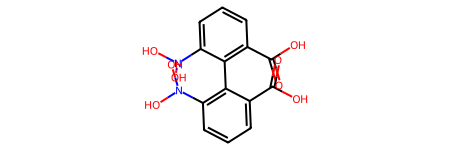

[]
Bond 8 stereo: STEREONONE
Bond 21 stereo: STEREONONE


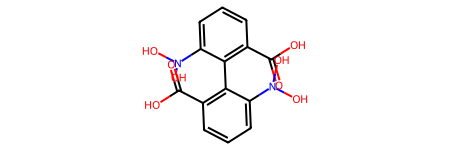

[]
Bond 8 stereo: STEREONONE
Bond 14 stereo: STEREONONE


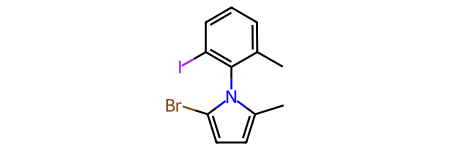

[]


[16:40:52] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 0 ignored
[16:40:52] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 0 ignored


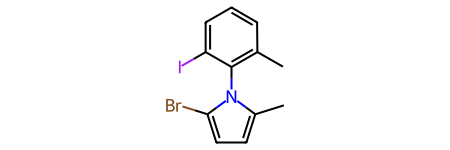

[]


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

[16:40:52] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 0 ignored
[16:40:52] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 0 ignored


In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'cis_trans_edges': True,
            'axial_chirality': True
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
from ptgnn.transform.ptree_matrix import permutation_tree_to_order_matrix

ptrees_selective = [
    {
        36: '{"S": [36, 37, {"C": [10, 26, 41, 39]}]}',
        37: '{"S": [37, 36, {"C": [39, 41, 26, 10]}]}'
    },
    {
        36: '{"S": [36, 37, {"C": [26, 10, 41, 39]}]}',
        37: '{"S": [37, 36, {"C": [39, 41, 10, 26]}]}'
    },
    {
        36: '{"S": [36, 37, {"C": [10, 26, 39, 41]}]}',
        37: '{"S": [37, 36, {"C": [41, 39, 26, 10]}]}'
    },
    {
        36: '{"S": [36, 37, {"C": [26, 10, 39, 41]}]}',
        37: '{"S": [37, 36, {"C": [41, 39, 10, 26]}]}'
    }
]
# set new permutation trees
for i in range(len(ptrees_selective)):
    for j, val in ptrees_selective[i].items():
        data_list[i].ptree[j] = val

# recompile order matrices, etc
data_list = [
    permutation_tree_to_order_matrix(data, 3)
    for data in data_list
]

In [9]:
for data in data_list:
    # print(data)
    # print(data.ptree)
    print([(idx, t) for idx, t in enumerate(data.ptree) if "C" in t])

[(36, '{"S": [36, 37, {"C": [10, 26, 41, 39]}]}'), (37, '{"S": [37, 36, {"C": [39, 41, 26, 10]}]}')]
[(36, '{"S": [36, 37, {"C": [26, 10, 41, 39]}]}'), (37, '{"S": [37, 36, {"C": [39, 41, 10, 26]}]}')]
[(36, '{"S": [36, 37, {"C": [10, 26, 39, 41]}]}'), (37, '{"S": [37, 36, {"C": [41, 39, 26, 10]}]}')]
[(36, '{"S": [36, 37, {"C": [26, 10, 39, 41]}]}'), (37, '{"S": [37, 36, {"C": [41, 39, 10, 26]}]}')]
[(28, '{"S": [28, 29, {"C": [10, 26, 31, 33]}]}'), (29, '{"S": [29, 28, {"C": [31, 33, 10, 26]}]}')]
[(28, '{"S": [28, 29, {"C": [10, 26, 31, 33]}]}'), (29, '{"S": [29, 28, {"C": [31, 33, 10, 26]}]}')]


## Create Model

In [10]:
k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k
    ))
    for _ in range(1)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (elu): ELU(alpha=1.0)
    )
  )
  (1): AdvancedPermutationTreeLayer(
    (p_layer): Linear(in_features=93, out_features=93, bias=False)
    (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
    (z_layer): ModuleList(
      (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
    )
    (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
    (s_layer): 

## Create batches

In [11]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [12]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ 1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan],
       [nan, nan, nan, nan,  1.,  1.],
       [nan, nan, nan, nan,  1.,  1.]])

## Put batches through model

In [13]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [14]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 1.,  0.,  0.,  0., nan, nan],
       [ 0.,  1.,  0.,  0., nan, nan],
       [ 0.,  0.,  1.,  0., nan, nan],
       [ 0.,  0.,  0.,  1., nan, nan],
       [nan, nan, nan, nan,  1.,  1.],
       [nan, nan, nan, nan,  1.,  1.]])

In [15]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True]])

In [21]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) < 0.00001)

array([[ True, False, False,  True, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [ True, False, False,  True, False, False],
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True]])

In [20]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0.00000000e+00, 1.88150723e-03, 1.88206648e-03, 4.15183604e-06,
                   nan,            nan],
       [1.88150723e-03, 0.00000000e+00, 3.38302925e-06, 1.88115705e-03,
                   nan,            nan],
       [1.88206648e-03, 3.38302925e-06, 0.00000000e+00, 1.88171631e-03,
                   nan,            nan],
       [4.15183604e-06, 1.88115705e-03, 1.88171631e-03, 0.00000000e+00,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
        0.00000000e+00, 0.00000000e+00],
       [           nan,            nan,            nan,            nan,
        0.00000000e+00, 0.00000000e+00]])

Distinguishes axial chirality after manually defining node trees